# Projet : Corrélation d'Images Numériques (DIC)

## Introduction

La corrélation d'image numérique ou digital image correlation (DIC) est une méthode numérique dont le résultat est de trouver 
le champ de déplacement u entre deux images de niveaux de gris qui correspondent à deux captures d'un même objet dans sa configuration de référence et sa configuration actuelle, une configuration où l'objet a subi des déformations.

Ainsi, en trouvant le champ de déplacement u, on pourra trouver les déformations et les contraintes appliquées au solide au travers des différentes lois qu'on connaît concernant les matériaux.

Le principe est le suivant :
On travaille sur le domaine $Ω_0$ : la configuration de référence et on souhaite trouver le déplacement u qui lie $Ω_0$ et
$Ω$ : la configuration actuelle (celle ayant subit une déformation par rapport à $Ω_0$)
Pour cela, on prend un point $X$ dans un domaine $D ⊂ Ω_0$ et un point $x$ dans $Ω$
$X$ et $x$ sont reliés par la relation : $x = X + u(X)$
On dispose aussi de deux fonctions $f$ et $g$ qui correspondent respectivement au niveau de gris de la configuration de référence et de la configuration actuelle. 
$f$ et $g$ sont reliés par : $g(X+u(X)) = f(X)$

Le problème peut se reformuler de la manière suivante : on cherche $u$ tel que $u$ minimise la fonction $J : u = argmin\ J(v)$ avec $v 𝜖 U_{adm}$
et $J(u) = \int{}(g(X + u(X)) - f(X))^{2} dV$
Cette méthode de résolution est une méthode de résolution pour un problème de types moindres carrés non linéaires.

Plusieurs algorithmes existent afin de résoudre ce type de problème.
Dans un premier temps, on regardera l problème en 1D et en comparant deux algorithmes qui peuvent résoudre ce problème : 
l'algorithme de Gauss-Newton et l'algorithme d'intercorrélation

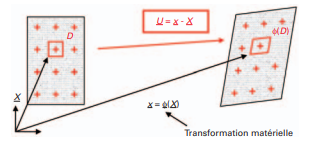

## 1ère Partie : Approche 1D

### Algorithme de Gauss-Newton

Cet algorithme repose sur le même principe que l'algorithme de Newton qui consiste à trouver les zéros d'une fonction en considérant une suite de la manière suivante : $x_{k+1} \ =\ x_{k} \ +\ \frac{f( x_{k})}{f'( x_{k})}$.
En partant d'un point $x_0$ en appliquant la méthode, $x_k$ sera solution de $f( x_{k}) \ +\ f'( x_{k})( x-x_{k}) =\ 0$
Dans notre cas, l'algorithme de Gauss-Newton consiste à minimiser le déplacement $u$ entre deux fonctions qu'on aura au préalable fourni.
Il fonctionne de la manière suivante : 
Soient deux fonctions $S$ : la configuration de référence et $s$ : la configuration actuelle
On souhaite minimiser :  $\int _{Ω}[ s( x) \ -\ S( X)]^{2} dΩ$
Lorsqu'on fait un développement de Taylor au second d'ordre de la fonction $J$, cela donne : $J( x\ +\ \delta x) \ \ =\ J( x) \ +\ \frac{\partial J( x)}{\partial x} \ .\ \delta x\ +\ \frac{1}{2}\frac{\partial ^{2} J( x)}{\partial x^{2}} .\delta x.\delta x\ +\ O\left( \mid \mid \delta x\mid \mid ^{3}\right)$

Le terme $\frac{\partial J( x)}{\partial x}$ correspond à la jacobienne de $J, j(x)$ et le terme $\frac{1}{2}\frac{\partial ^{2} J( x)}{\partial x^{2}}$ correspond à la hessienne de $J, H(x)$

Dans l'algorithme $\delta x$, vaudra $-j( x) .H( x)^{-1}$ puis à chaque itération, tant que $\mid \mid \delta x\mid \mid >\epsilon$, $x_{k+1} \ =\ x_{k} \ +\ \delta x$

Le dernier terme au sortir de la boucle nous donnera, le déplacement $u$

Les coordonnées d'arrivées seront $x = X +N(X)*u$ 

### 1er cas : la translation uniforme

On souhaite trouver le déplacement $u$ tel que : $g(x) = f(x+u)$ 

c'est-à-dire, tels que $u$ soit une constante

### Importation des librairies utiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

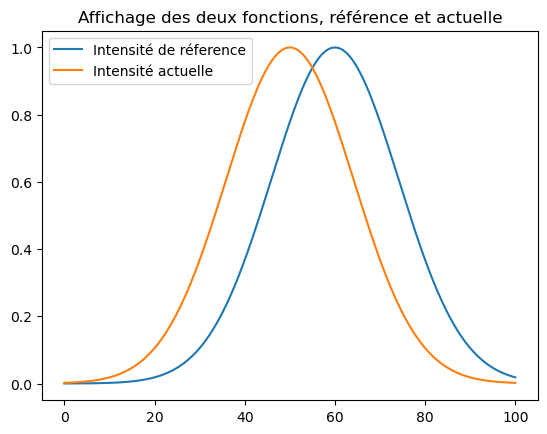

In [2]:
# On définit les paramètres de nos deux fonctions

Nbr = 100 # nombre de points
sigma  = 20
sigma1 = 0.1*Nbr 
sigma2 = sigma*1.1 
mu1 = 60 # étalement de reference
mu2 = 50 # étalement actuelle

# Signal de reference
def reference(X):
    return np.exp(-(X-mu1)**2/sigma**2)

# Signal déformé 
def deforme(X):
    return np.exp(-(X-mu2)**2/sigma**2)

# On affiche les deux fonctions
X = np.linspace(0,100,1000)
plt.plot(X,reference(X),label='Intensité de réference')
plt.plot(X,deforme(X),label='Intensité actuelle')
plt.title("Affichage des deux fonctions, référence et actuelle")
plt.legend()
plt.show()


On voit bien à partir de la figure qu'on doit trouver après calcul un déplacement égal à 10.

### Introduction des Fonctions Utiles

On définit l'ensemble des fonctions qui nous seront utiles pour réaliser l'algorithme de Gauss-Newton

In [3]:
# On définit la jacobienne qui prend en paramètres un déplacement initial fourni, une fonction f dont trouvera la jacobienne 
# un paramètre h qui sera utile pour la définition de la jacobienne qui est un vecteur où les composantes sont : 
# f(u[i+h]-u[i])/h

def jacobian(u, f, h=1e-3, *args) :
    nb_parametres = u.shape[0]
    j = np.zeros(nb_parametres)

    for i in range(nb_parametres):
        u_plus_h = u.copy()
        u_plus_h[i] += h

        v_a = f(u_plus_h, *args)
        v_b = f(u, *args)

        j[i] = (v_a - v_b) / h

    return j

# On définit la hessienne qui prend les mêmes paramètres que la jacobienne et qui renvoie une matrice composée des dérivées
# seconde de f par rapport au variable de u. Cela revient à dériver les composantes de la jacobienne de la manière suivante
# J(u[i+h]-u[i])/h
def hessian(u, f, h, *args):
    nb_parametres = u.shape[0]
    H = np.zeros((nb_parametres, nb_parametres))

    for i in range(nb_parametres):
        for k in range(nb_parametres):
            u_plus_h = u.copy()
            u_plus_h[k] += h
            v_a = jacobian(u_plus_h, f, h, *args)[i]
            v_b = jacobian(u, f, h, *args)[i]
            H[i][k] = (v_a - v_b) / h
    return H

# On définit une fonction qui permet d'afficher les courbes plus facilement au lieu de réecrire à chaque l'ensemble des graphes
def PlotAll(X, titre,*args):
    for (curve, legend) in args:
        plt.plot(X, curve, label=legend)
        plt.title(titre)
    plt.legend()
    plt.show()

# on crée une fonction du qui renvoie 1e10 fois un tableau composé de 1 qui est la valeur initiale de du
def set_up_du(u):
    return 1e10 * np.ones(u.shape[0])

# on définit le gradient du signal qui prend en paramètres le signal s, un tableau de point initial X, et un paramètre h et qui 
# renvoie le gradient du signal sous forme d'une matrice diagonale où la diagonale est le vecteur gradient
def grad_signal(s, X, h=1e-3):
    grad = []
    for i in range(X.shape[0]):
        g = (s(X[i] + h) - s(X[i]))/h
        grad.append(g)

    return np.diag(np.array(grad))


# On définit la dérivée de la fonction J de la manière suivante les points d'arrivés x sont réécrit de la manière suivante
# x = X + N(X)*u avec N(X) : les fonctions de forme et u : le déplacement initial qui sera redéfinit à chaque nouvelle itération
# dans l'algorithme de Gauss Newton
# Elle prend en paramètres u, N, actual qui est la fonction de référence, target qui est la fonction de actuelle et les points 
# initials X
def dJ_new(u, N, actual, target, X):
    # On définit les points d'arrivée
    x = X + np.dot(N(X), u)
    # on définit le résidu r qui est la différence entre actual et target
    r = actual(x) - target(X)
    # On définit la dérivé de r par rapport à x qui est le gradient du signal actual avec la fonction de forme N
    dr_dx = np.dot(grad_signal(actual, x), N(X))
    # On retourne la jacobienne définit par le produit entre dr_dx et r
    jacob = np.dot(np.transpose(dr_dx), r)
    return jacob

# On définit la dérivée seconde de la fonction J qui sera définit de la même manière que pour dJ_new d
# Elle prend en paramètres u, N, actual qui est la fonction de référence, target qui est la fonction de actuelle et les points 
# initials X
def ddJ_new(u, N, actual, target, X):
    x = X + np.dot(N(X), u)
    g = grad_signal(actual, x)
    N = N(X)
    N_t = np.transpose(N)
    g_t = np.transpose(g)
    inter_1 = np.dot(N_t,g_t)
    inter_2 = np.dot(g,N)
    hess = np.dot(inter_1,inter_2)
    return hess


In [4]:
# On réalise l'algorithme de Gauss_Newton qui prend en paramètre u, N, actual qui est la fonction de référence, 
# target qui est la fonction de actuelle, les points initials X, epsilon = 1e-6 et le nombre d'itérations maximum = 1000

def GaussSolver_1D(u, N, actual, target, X, eps = 1e-6, max_iter = 1000):
    # Le premier u_optimal vaut u initial qu'on a fournit
    u_opt = u
    # On fixe la première itération à 0
    iter = 0
    # on définit du
    du = set_up_du(u)
    # on définit l'erreur 
    err = np.sqrt(np.sum(du**2))
    # On rentre dans la boucle 
    while err > eps and iter < max_iter:
        # On définit la jacobienne de J
        j = dJ_new(u_opt, N, actual, target, X)
        # On définit la Hessienne de J
        H = ddJ_new(u_opt, N, actual, target, X)
        # On définit le nouveau du qui vaut du = j*H^(-1)
        # pour éviter de tomber sur une matrice singulière (non inversible), on réalise un résolution normale si H est inversible
        # et sinon on réalise une pseudo-inverse
        try:
            du = np.linalg.solve(H, j)
        except:
            du = np.dot(np.linalg.pinv(H), j)
        
        # Le nouveau u_optimal vaut l'anciènne valeur - le nouveau du
        u_opt = u_opt - du
        # on redéfinit l'erreur avec le nouveau du
        err = np.sqrt(np.sum(du**2))
        # On augmente l'itération de 1
        iter += 1
    print("Le nombre d'itérations vaut :",iter)
    # On est sorti de l'algorithme, on définit des variables qui nous serviront à afficher le signal de référence, le signal 
    # actuelle et le signal en ayant appliquer le déplacement fournit par l'algorithme
    actual_signal_first_iter = actual(X)
    final_x = X + np.dot(N(X), u_opt)
    final_actual_signal = actual(final_x)
    target_signal = target(X)

    PlotAll(X,"Affichage des trois fonctions, référence, actuelle et actuelle avec G-N", (target_signal, "Intensité actuelle"), (actual_signal_first_iter, "Intensité référence"), (final_actual_signal, "Intensité actuelle avec G-N"))
    return u_opt


Le nombre d'itérations vaut : 4


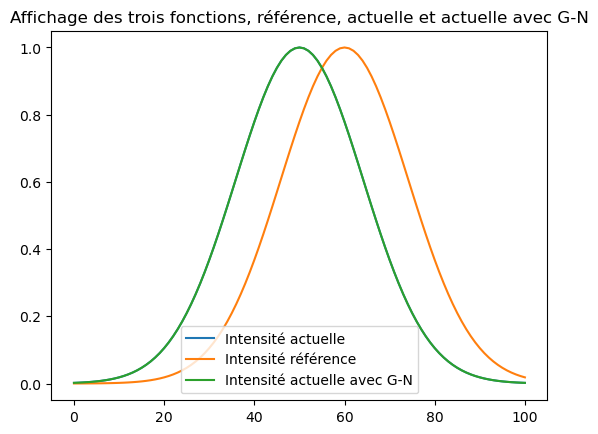

[10.]


In [5]:
# On crée une fonction évalutation 1D, où on définit les fonctions où on cherche le déplacement et la fonction de forme

def Eval_1D():
    # target et actual sont les deux fonctions où on cherche le déplacement
    def target(x):
        return np.exp(-(x - mu2) ** 2 / sigma ** 2)

    def actual(x):
        return np.exp(-(x - mu1) ** 2 / sigma ** 2)
    
    # On fournit une valeur initiale à u
    u = np.array([0.0])
    # On définit la fonction de forme
    def N(x):
        ones = np.ones((x.shape[0], 1))
        return ones
    
    # On définit les points initiales
    X = np.arange(0, Nbr + 1)
    
    # On réalise l'algorithme
    u_opt = GaussSolver_1D(u, N, actual, target, X)
    print(u_opt)

Eval_1D()

On peut aussi essayer en prenant $u$ comme une transformation affine $u = ax + b$

Cela est simple à modifier car il suffit de modifier la fonction de forme et les deux fonctions, l'algorithme ne change pas

Le nombre d'itérations vaut : 7


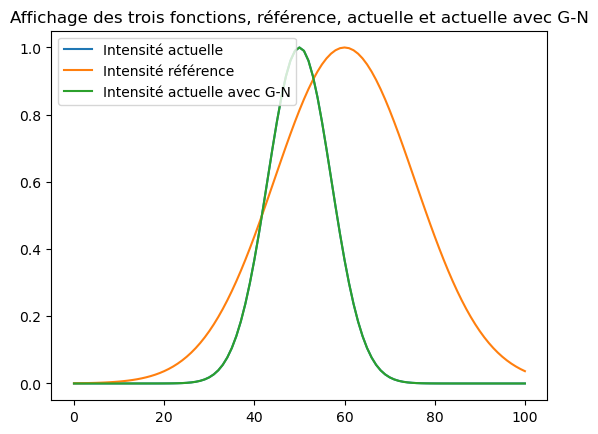

[  1.2 -50. ]


In [6]:
# On crée une fonction évalutation 1D, où on définit les fonctions où on cherche le déplacement et la fonction de forme

def Eval_1D():
    # target et actual sont les deux fonctions où on cherche le déplacement
    def target(x):
        return np.exp(-(x - mu2) ** 2 / sigma1 ** 2)

    def actual(x):
        return np.exp(-(x - mu1) ** 2 / sigma2 ** 2)
    
    # On fournit une valeur initiale à u
    u = np.array([0.0,0.0])
    # On définit la fonction de forme
    def N(x):
        x_expanded = np.expand_dims(x, axis=-1)
        ones = np.ones((x.shape[0], 1))
        a = np.concatenate([x_expanded, ones], axis=1)
        return a
    
    # On définit les points initiales
    X = np.arange(0, Nbr + 1)
    
    # On réalise l'algorithme
    u_opt = GaussSolver_1D(u, N, actual, target, X)
    print(u_opt)

Eval_1D()

De la même manière que pour la translation uniforme, on voit que l'algorithme fonctionne bien car les deux fonctions, actuelle et déformée se superposent.
On peut aussi réaliser une deuxième méthode pour trouver le déplacement, l'intercorrélation.

### Algorithme d'Intercorrélation

La méthode spécifique que nous allons utiliser se nomme l'intercorrélation, elle a pour faculté de mesurer la similarité entre deux images. L'intercorrélation revient à calculer la somme suivante: 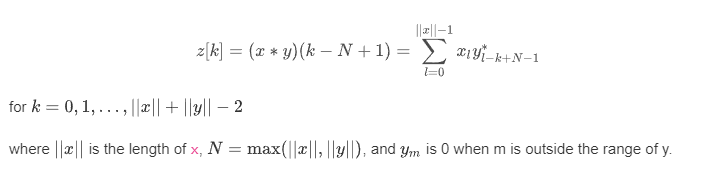

Cette méthode revient à faire bouger un signal sur l'intervalle étudié en relevant le déplacement et la similitude entre les signaux. Lorsque la similitude est maximale (à savoir quand la corrélation est maximale),les signaux sont superposés et on peut alors relever le déplacement correspondant à cette valeur maximale. 

L'intercorrélation à beaucoup de propriétés en commun avec le produit de convolution, notamment avec les Fast Fourier Transform (FFT), ce qui permet de calculer de façon plus simple en passant dans l'espace de Fourier. À partir de cette méthode et de deux signaux, on peut retrouver le déplacement d'une translation uniforme. Dans la suite, nous utiliserons un signal gaussien définit par la fonction "gaussian" et nous allons le déplacer d'une valeur u inconnu grâce à la fonction random. On appliquera l'algorithme nommé "déplacement" aux deux signaux f et g. Celui-ci calculera le vecteur contenant la corrélation ainsi que les indices de déplacement. On récupère l'argument maximal de la corrélation, c'est-à-dire l'endroit où les signaux sont les plus semblables, cela permettra d'injecter l'indice de cet argument dans la matrice des déplacements et ce qui renverra à une multiplication près avec le pas spatial, le déplacement de notre signal.

déplacement: 20


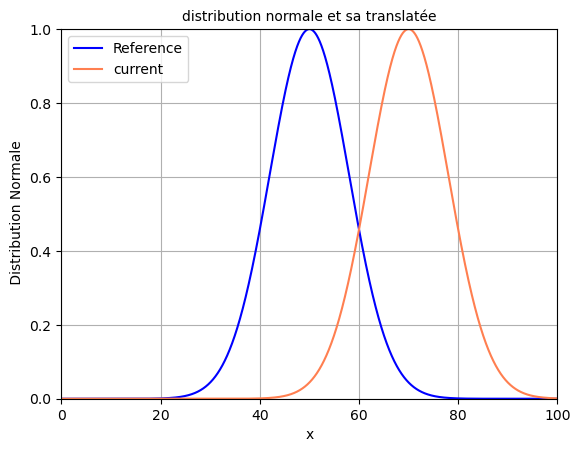

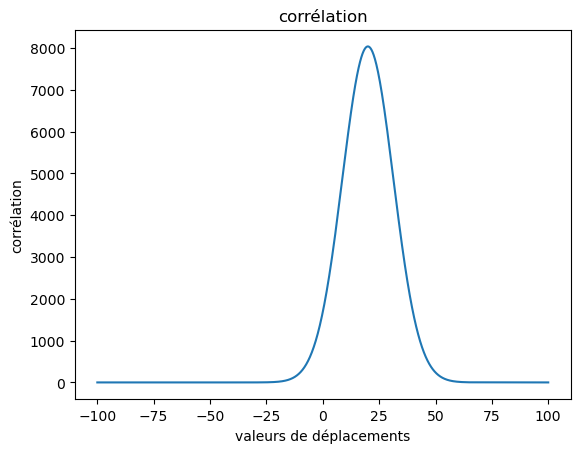

le déplacement calculé numériquement vaut: 19.999294619704674


In [7]:
import random
import scipy
import pandas as pd
from scipy import signal
def gaussian(sigma,mu,x):
    return np.exp(-((x-mu)**2)/(2*sigma**2))

x_min = 0.0
x_max = 100
x = np.linspace(x_min, x_max, 56708)
sigma = 8
mu =50

u= random.randint(5,20)
print('déplacement:',u)

plt.plot(x,gaussian(sigma,mu,x), color='blue')
plt.plot(x,gaussian(sigma,mu,x-u), color='coral')
plt.legend(['Reference','current'])
plt.grid()
plt.xlim(x_min,x_max)
plt.ylim(0,1.0)

plt.title('distribution normale et sa translatée',fontsize=10)

plt.xlabel('x')
plt.ylabel(' Distribution Normale')
plt.savefig('shifted_gaussian.png')
plt.show()


f=gaussian(sigma,mu,x)
g=gaussian(sigma,mu,x-u)
med=np.median(np.diff(x))
corr = scipy.signal.correlate(f, g,mode='full')
lag=scipy.signal.correlation_lags(f.size, g.size, mode="full")
plt.plot(-lag*med,corr)
plt.title("corrélation")
plt.xlabel('valeurs de déplacements')
plt.ylabel('corrélation')
plt.savefig("cross_correlation")
plt.show()


def déplacement(f,g,coord):
   
    pas_spatial  = np.median(np.diff(coord)) #dans notre cas, c'est le pas spatial
    correlation = signal.correlate(f, g, mode="full")
    lags = signal.correlation_lags(f.size, g.size, mode="full")
    lag = lags[np.argmax(correlation)]
    spacial_lag = lag*pas_spatial
    
    return spacial_lag


print('le déplacement calculé numériquement vaut:',-déplacement(f,g,x))

On obtient bien le déplacement avec une erreur assez petite, ce qui est satisfaisant. Le graphique de la corrélation illustre bien la recherche du maximum de déplacement lorsque les signaux sont les plus similaires.

## 2ème Partie : Approche 2D

### Algorithme de Gauss-Newton

On peut maintenant passer à l'étude qu'on souhaitait initialement avec la comparaison entre deux images de niveaux de gris pour trouver le déplacement entre ces deux images. Pour cela, on réappliquera l'algorithme de Gauss-Newton mais en 2D. La différence entre la 1D et la 2D n'est pas énorme, la différence provient du fait que le déplacement se fait selon deux directions, les pixels x et y, on doit donc créer deux fonctions de formes $Nx$ et $Ny$ .

L'algorithme se présente comme cela :
On a deux matrices de niveaux de gris $F$ et $G$ qui sont les matrices de niveaux de gris respectivement de référence et actuelle.
On se concentre sur la matrice de G.
A partir de celle-ci, on crée les deux gradients $\nabla G_x$ et $\nabla G_y$ selon les pixels $x$ et $y$ de la même manière que pour l'algorithme en 2D.

$\nabla G_{x} \ =\ ( G( X\ +\ [ h,0]) -G( X)) /h$

$\nabla G_{y} \ =\ ( G( X\ +\ [ 0,y]) -G( X)) /h$

On crée la matrice L, de la manière suivante : $L\ =\ \nabla G_{x} *N_{x}( X) \ +\ \nabla G_{y} *N_{y}( X)$

De même, on définit le résidu $R$, qui est la différence entre les deux niveaux de gris $R = F-G$ 

À partir de cela, on peut créer la jacobienne et la Hessienne : $j = L^{T} R$ et $H = L^{T}L$

La définition de toutes ces variables, on peut appliquer l'algorithme qui ne varie pas par rapport à celle 1D.

La complexité vient du fait qu'il faut bien comprendre les dimensions de toutes les variables.

Si on se fixe un domaine $D$ de taille $(px,py)$ dans les deux images alors regardons les dimensions de toute les variables.

Le domaine $D$ est carré donc $px=py$

$G$ et $F$ qui sont les matrices de niveaux de gris sont de dimensions $(px,py)$

$\nabla G_{x}$ et $\nabla G_{y}$ sont de même de dimensions $(px,py)$

On prend $X$ : le vecteur des coordonnées de $x$, les pixels selon $x$ de dimension $px$

et $Y$ : le vecteur des coordonnées de $y$, les pixels selon $y$ de dimension $py$

Dès lors, on prend $N_{x}$ de la forme $[ 1\ 0\ Y \ X \ 0\ Y]$ et $N_{y}$ de la forme $[ 0\ 1\ -X \ 0 \ Y\ X]$, ils sont toutes les deux de dimensions $(px*py,6)$

Afin de pouvoir réaliser le produit $\nabla G_{x} *N_{x}( X)$ il faut changer la dimension de $\nabla G_{x}$, pour cela on transforme la matrice $\nabla G_{x}$ en un vecteur de taille $(px*py,1)$ en mettant les lignes à la suite l'une de l'autre puis on créer une matrice diagonale de taille $(px*py,px*py)$ où la diagonale est le vecteur $\nabla G_{x}$

Dès lors $L$ est de dimension $(px*py,px*py) * (px*py,6) + (px*py,px*py) * (px*py,6) = (px*py,6)$

$R$ est de dimension $(px,py)$

De la même manière, on change la dimension de $R$ afin de réaliser le produit le jacobien, $R$ devient un vecteur de taille $(px*py,1)$

Le jacobien $j = L^{T} R$ est de dimension $(6,px*py) * (px*py,1) = (6,1)$

La hessienne $H = L^{T}L$ est de dimension $(px*py,6)*(6,px*py) = (px*py,px*py)$

Les coordonnées d'arrivées seront $x = X + N_{x}u + N_{x}u$

Après avoir défini, toutes les variables et leurs dimensions, on peut débuter le codage de l'algorithme

### Importation des librairies utiles

In [4]:
from PIL import Image
from scipy import ndimage

In [5]:
#On ouvre les deux images dont on va étudier le déplacement

img1 = Image.open(r'img_001.png')
img2 = Image.open(r'img_002.png')
matrice_pixel_im_ini = []
matrice_pixel_im_def = []

#On définit le domaine D
range_ = 200
start = 300
# On crée les matrices de niveaux de gris
for x in range(start,start + range_):
    niv_gris_1 = []
    niv_gris_2 = []
    # Si vos images sont au format 'jpg', décommenter les 4 lignes en-dessous car le format 'jpg' est codé selon 3 composantes
    for y in range(start, start + range_):
        g_1 = img1.getpixel((x,y))
        #if len(g_1) == 3:
            #g_1 = 0.33 * (g_1[0] + g_1[1] + g_1[2])
        g_2 = img2.getpixel((x,y))
        #if len(g_2) == 3:
            #g_2 = 0.33 * (g_2[0] + g_2[1] + g_2[2])
        niv_gris_1.append(g_1 / 255.0)
        niv_gris_2.append(g_2 / 255.0)
    matrice_pixel_im_ini.append(niv_gris_1)
    matrice_pixel_im_def.append(niv_gris_2)

matrice_px_im_ini = np.array(matrice_pixel_im_ini, dtype=float)
matrice_px_im_def = np.array(matrice_pixel_im_def, dtype=float)

# On affiche les images
img1.show()
img2.show()

In [4]:
# Fonction d'interpolation, on va interpoler les images 
def inter2D_ex(X, img):
    # On récupère la hauteur et la largeur de l'image
    width = img.shape[0]
    height = img.shape[1]
    
    # On récupère les pixels selon x et selon y
    x = X[:,:,0]
    y = X[:,:,1]
    a = np.array([x, y])
    # On interpole l'image avec un mode afin que l'on ait pas de discontinuité au niveau des bords
    tmp = ndimage.map_coordinates(img, a, order=3,mode = 'reflect')
    # On récupère un vecteur dont on change la dimension pour obtenir notre nouvelle image interpoler
    result = np.reshape(tmp, (width, height))
    return result

# Création du gradient selon X, il prend en paramètre le niveau de gris de G (s), la matrice pixel X et une variable h
def gradientGx(s, X, h=1e-3):
    # On récupère la hauteur et la largeur de X
    width = X.shape[0]
    height = X.shape[1]
    
    # On réalise le calcul décrit précedemment
    # On ajoute à chaque pixel x, h puis on fait la différence entre le nouveaux et l'ancien diviser par h
    X_plus_h = X + np.array([h, 0])
    s_X_plus_h = s(X_plus_h)
    s_x = s(X)
    diff = (s_X_plus_h - s_x) / h
    # On change en vecteur, la matrice gradient Gx
    tmp = np.reshape(diff, (width * height))
    # On change en une matrice diagonale le vecteur gradient Gx
    result = np.diag(tmp)
    return result

# On fait la même que pour x mais pour la composante y
def gradientGy(s, X, h=1e-3):
    width = X.shape[0]
    height = X.shape[1]

    X_plus_h = X + np.array([0, h])
    s_X_plus_h = s(X_plus_h)
    diff = (s_X_plus_h - s(X)) / h
    tmp = np.reshape(diff, (width * height))
    result = np.diag(tmp)
    return result

# On créer la matrice L comme décrit au-dessus
def matrice_L(gradGx,gradGy,Nx,Ny,X):
    N_x = Nx(X)
    N_y = Ny(X)
    L = np.dot(gradGx,N_x) + np.dot(gradGy,N_y)
    return L

# On crée une fonction qui crée la coordonnées d'arrivée x : x_ = X_ + N * u avec N = Nx + Ny et X_ = X + Y
# Plus précisemment: x = X + Nx * u et y = Y + Ny * u
# Cela nécessitera des opérations de changement de dimension

def to_x(u, X, Nx, Ny):
    width = X.shape[0]
    height = X.shape[1]
    
    # la dimension de x_tmp.shape est (width * height) c'est un vecteur
    x_tmp = np.dot(Nx(X), u)
    # on change la dimension de x_tmp pour qu'il devienne une matrice de taille (width, height)
    # on utilise expand_dims pour la concatenation afin que x_tmp devienne un tenseur d'ordre 2 dans R^3
    # la dimension sera (width, height,1)
    # x_offset = Nx * u
    x_offset = np.expand_dims(np.reshape(x_tmp, (width, height)), axis=-1)
    
    # On fait les mêmes opérations pour y_tmp
    y_tmp = np.dot(Ny(X), u)
    y_offset = np.expand_dims(np.reshape(y_tmp, (width, height)), axis=-1)
    
    # On fait une concatenation selon la dernière dimension, full_offset est de dimension (width, height, 2)
    full_offset = np.concatenate([x_offset, y_offset], axis=-1)
    
    # On obtient la nouvelle coordonnées
    x = X + full_offset
    return x


# On définit la jacobienne
def jacob2D(u, s, S, L, Nx, Ny, X):
    width = X.shape[0]
    height = X.shape[1]
    x = to_x(u, X, Nx, Ny)
    r = s(x) - S(X)
    # On fait le changement de dimension définit au-dessus pour R
    tmp = np.reshape(r, (width * height))

    jacob2D = np.dot(np.transpose(L), tmp)
    return jacob2D

# On définit la Hessienne
def Hessienne2D(L):
    return np.dot(np.transpose(L),L)

# On définit du
def set_up_du(u):
    return 1e10 * np.ones(u.shape[0])

In [5]:
# On réalise l'algorithme de Gauss-Newton 2D de la même manière que pour la 1D

def GaussSolver_2D(u, Nx, Ny, s, S, X, eps = 1e-6, max_iter = 10):
    u_opt = u
    iter = 0
    du = set_up_du(u)
    err = np.sqrt(np.sum(du ** 2))
    while err > eps and iter < max_iter:
        x = to_x(u_opt, X, Nx, Ny)
        Gx = gradientGx(s, x)
        Gy = gradientGy(s, x)
        L = matrice_L(Gx, Gy, Nx,  Ny, X)
        j = jacob2D(u, s, S, L, Nx, Ny, X)
        H = Hessienne2D(L)
        try:
            du = np.linalg.solve(H, j)
        except:
            du = np.dot(np.linalg.pinv(H), j)
        u_opt = u_opt - du
        err = np.sqrt(np.sum(du ** 2))
        iter += 1
    return u_opt

In [63]:
# Création des fonctions des niveaux de gris

def Eval_2D():
    def s(x) : 
        values = inter2D_ex(x, matrice_px_im_ini)

        return values

    def S(x) :
        values = inter2D_ex(x, matrice_px_im_def)
        return values

    # Initialisation de u
    u = np.array([0.0, 0.0,0.0,0.0,0.0,0.0])

    # Création des deux fonctions de formes Nx et Ny
    def Nx(x):
        width = x.shape[0]
        height = x.shape[1]
        nbr_px = width * height

        x_0_tmp = x[:,:,0]
        x_1_tmp = x[:,:,1]
        x_0 = np.reshape(x_0_tmp, (nbr_px, 1))
        x_1 = np.reshape(x_1_tmp, (nbr_px, 1))
        ones = np.ones([nbr_px, 1])
        zeros = np.zeros([nbr_px, 1])

        a = np.concatenate([ones, zeros, x_1, x_0, zeros, x_1], axis=-1)
        return a

    def Ny(x):
        width = x.shape[0]
        height = x.shape[1]
        nbr_px = width * height

        x_0_tmp = x[:,:,0]
        x_1_tmp = x[:,:,1]
        x_0 = np.reshape(x_0_tmp, (nbr_px, 1))
        x_1 = np.reshape(x_1_tmp, (nbr_px, 1))
        ones = np.ones([nbr_px, 1])
        zeros = np.zeros([nbr_px, 1])

        a = np.concatenate([zeros, ones, -x_0, zeros, x_1, x_0], axis=-1)
        return a
    
    
    # Création de la matrice pixel 
    width = len(matrice_pixel_im_ini)
    height = len(matrice_pixel_im_ini[0])
    X = np.zeros((width, height, 2))
    for i in range(width):
        for j in range(height):
            X[i][j][0] = i
            X[i][j][1] = j

    u_opt = GaussSolver_2D(u, Nx, Ny, s, S, X)
    final_x = to_x(u_opt, X, Nx, Ny)
    
    # On récupère les trois images
    gray_values_of_actual_image = s(X)
    gray_values_of_deformed_image = s(final_x)
    gray_values_of_target_image = S(X)
    
    image_A = 255*np.reshape(gray_values_of_deformed_image, (width, height))
    image_B = 255*np.reshape(gray_values_of_target_image, (width, height))
    image_C = 255*np.reshape(gray_values_of_actual_image, (width, height))
    diff = np.abs(image_A - image_B)
    
    # On transforme en image les matrices 
    difference = Image.fromarray(diff)
    image_deformed = Image.fromarray(image_A)
    image_target = Image.fromarray(image_B)
    image_actual = Image.fromarray(image_C)
    
    # On affiche le déplacement et les images
    image_target.show()
    difference.show()
    image_deformed.show()
    print(u_opt)

Eval_2D()

[-2.38908413e+00  1.30649472e-02  8.00979052e-05 -2.38559425e-03
  7.26250183e-04 -4.81453066e-04]


On a testé avec l'algorithme deux images qui sont dans le dossier attaché au notebook, l'image $img001.png$ qui est la configuration de référence et l'image $img002.png$ qui est la configuration actuelle, on en détache un domaine $D$ pour chacun ($Domainereference.png$ et $Domaineactual.png$) qu'on peut observer sur les 2 images suivantes ($actual.png$ et $reference.png$).
On obtient à partir de l'algorithme de $Gauss-Newton$ un domaine $D$ ($image GN.png$).
On ne peut voir aucune différence à l'oeil nu, c'est pour cela qu'on fait la différence entre les niveaux de gris de l'image actuelle et de l'image de $Gauss-Newton$ ($image Difference.png$).

On observe que l'algorithme n'a pas fonctionné totalement car on n'a pas une uniformisation de la couleur noire qui correspond à une correspondance totale entre les deux. On a plutôt beaucoup de noirs et de gris foncé, ce qui signifie que les deux images sont proches, ainsi l'algorithme n'a pas produit de résultat aberrant mais n'est pas totalement précis.

Néanmoins, le résultat fourni nous donne un déplacement qui serait essentiellement une translation selon x $(-2.38908413)$ car la translation selon y $(1.30649472e-02)$, la rotation $(8.00979052e-05)$, les déformations longitudinales $(-2.38559425e-03, 7.26250183e-04)$ et le cisaillement $(-4.81453066e-04)$ sont faibles devant le déplacement selon x.

### principe d'intercorrélation 2D

La mesure de la déformation d'un objet, lorsqu'on prend successivement plusieurs photos, consiste à retrouver des fragments de la première image dans la seconde. C'est là tout le principe de l'intercorrélation. Ce programme étant plus complexe à coder, nous nous sommes inspirés d'un article de Aurélien Augier : https://planet-terre.ens-lyon.fr/ressource/correlation-images.xml#resolution. Le programme qu'il a réalisé était intéressant pour comprendre cette deuxième méthode dans le cas 2D, puisque contrairement au notre il utilise cv2 pour faire la corrélation et arrive à déterminer le déplacement y compris dans le cas affine.

On commence alors par ouvrir les images que nous allons étudier dans imgMai et imgEsc, qui correspondent aux images 'maîtresses' et 'esclaves'. L'image maîtresse étant l'image de référence, caractérisant le matériau au repos; l'image esclave quant à elle est une translation des points de l'image maîtresse, dont le déplacement nous est pour l'instant inconnu.

La méthode veut qu'on définisse un domaine de l'image maîtresse et de l'image esclave, c'est-à-dire une zone où le déplacement est censé être le maximum. Ici c'est dans la partie centrale, entre les deux bords à gauche et à droite, que la déformation se fait. L'élément de l'image maître qui va successivement parcourir l'image esclave. Pour cela évidemment la taille du fragment maître doit être inférieure au domaine de l'image esclave sinon rien ne se passera. Notre algorithme va ensuite calculer la corrélation entre la portion de l'image maitresse et la portion de l'image esclave. On définit une grille qui va recouvrir l'image et on crée deux tableaux DC et DL.

Afin de remplir les deux matrices DC et Dl caractérisant respectivement les déplacements selon les colonnes et les déplacements selon les lignes, il va falloir faire deux boucles, qui vont permettre de calculer les déplacements sur chaque point de la grille. En effet dans le cas 2D, il faut parcourir à la fois les lignes et les colonnes. Autour de chaque point on détermine une zone de l'image maîtresse et une zone de l'image esclave que l'on extrait des matrices d'image. Ces deux zones sont dans zones assez proche ce qui va permettre de ne pas gacher trop de mémoire de calcul lorsqu'on va calculer l'intercorrélation. Une fois calculé, on n'a plus qu'à en extraire les informations et à représenter les résultats de manière graphique.

pixel central : ligne 845, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 828, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 811, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 794, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 777, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 760, colonne 355
decalage en colones : 1.5 pixels (positif vers la droite)
decalage en lignes  : 0.5 pixels (positif vers le haut)
pixel central : ligne 743, colonne 355
decalage en colones : 1.5 pixels (positif v

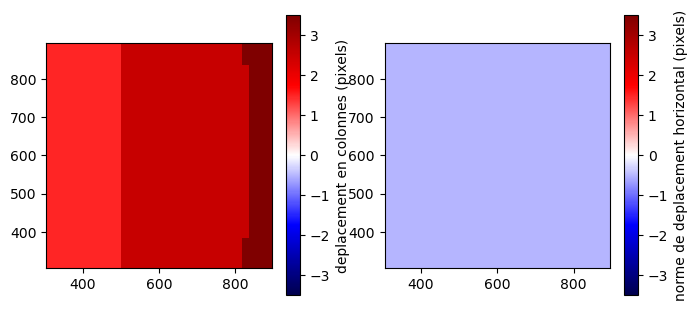

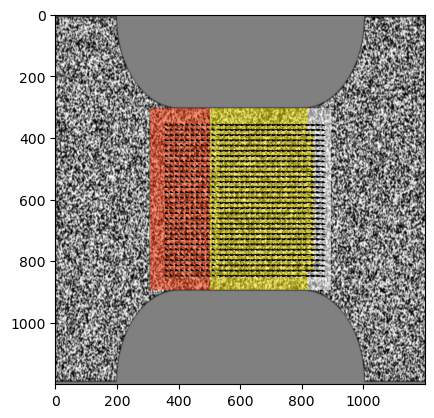

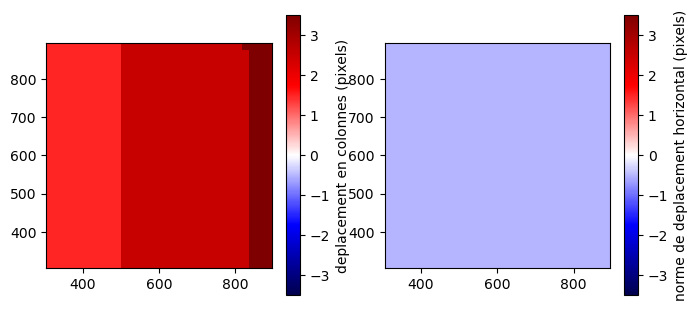

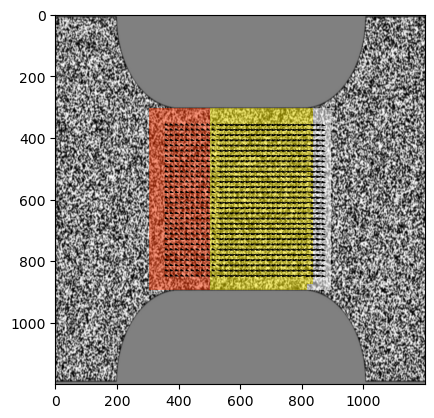

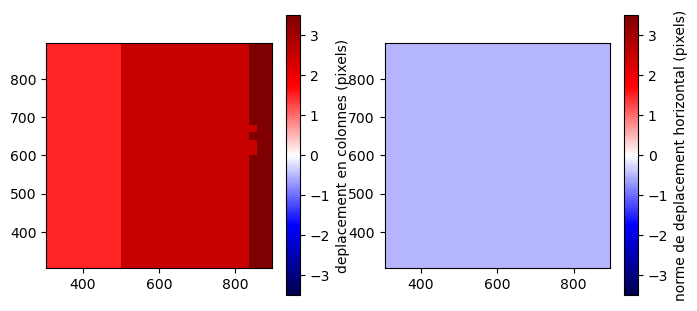

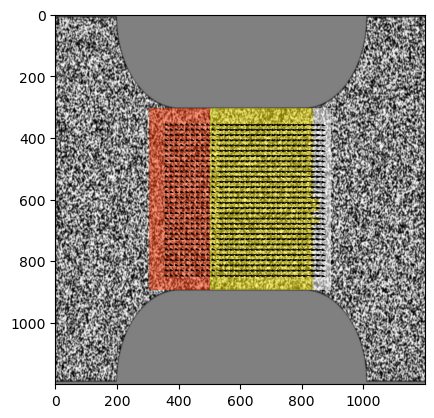

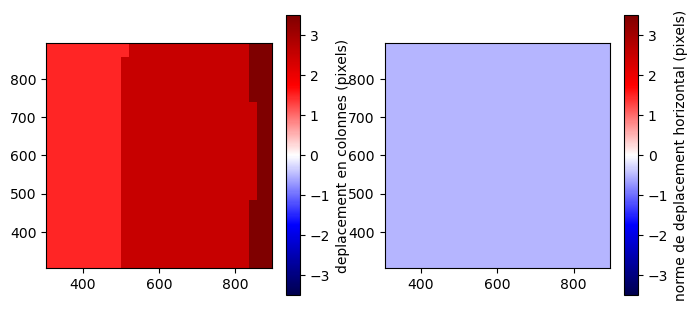

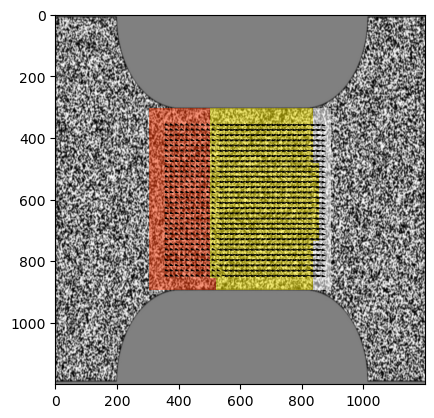

In [13]:

import numpy as np # pour du calcul sur des matrices
import cv2 # pour correlation
from matplotlib import pyplot as plt # pour les graphiques
import matplotlib.image as mpimg # pour ouverture images en format numpy
for i in range(1,5):
    # ouverture des images
    #les images ont étés redimensionnées car le programme d'origine nécéssitait cela
    imgMai = mpimg.imread('img_00'+str(i)+'.jpg') # image Maitresse
    imgEsc = mpimg.imread('img_00'+str(i+1)+'.jpg') # image Esclave
    
    # taille en pixel du fragment de l'image Maitresse
    # (ce qu'on va rechercher dans l'image Esclave)
    dxy = 100
    
    # taille en pixel du fragment de l'image Esclave dans laquelle 
    # on va rechercher le fragment de l'image Maitresse. Doit etre plus grand
    # que taille du fragment de l'image Maitresse
    ddxy = 355
    
    # nombre de calculs en lignes et en colonnes. Plus ce nombre est grand, plus
    #le resultat final sera fin, mais plus il demandera du temps. (30 est un bon compromis)
    nP = 30
    
    #creation d'une grille de coordonnees sur lesquelles se feront les calculs
    grilleC,grilleL = np.meshgrid(np.linspace(ddxy,imgMai.shape[0]-ddxy,nP),np.linspace(imgMai.shape[1]-ddxy,ddxy,nP))
    grilleC=grilleC.astype(int)
    grilleL=grilleL.astype(int)
    
    #creation de deux tableaux vides qui contiendront les deplacements en lignes et colonnes
    DC = np.zeros(grilleC.shape)
    DL = np.zeros(grilleC.shape)
    
    # pour chaque coordonnees de la grille, on fait le calcul de correlation
    for c in range(grilleC.shape[1]):
        for l in range(grilleC.shape[0]):
            pixcentrel = grilleL[l,c] #ligne 
            pixcentrec = grilleC[l,c]
    
            # coordonnee du fragments dans l'image Esclave
            zoneEsc = (pixcentrel-ddxy/2,pixcentrec-ddxy/2,pixcentrel+ddxy/2,pixcentrec+ddxy/2)
            
            # coordonnee du fragments dans l'image Maitresse : centree sur 
            zoneMai = (pixcentrel-dxy/2,pixcentrec-dxy/2,pixcentrel+dxy/2,pixcentrec+dxy/2)
            
            
            # extraction des fragments d'interet des images maitre et esclave
            extraitMai = imgMai[int(zoneMai[0]):int(zoneMai[2]),int(zoneMai[1]):int(zoneMai[3]),:]
            extraitEsc = imgEsc[int(zoneEsc[0]):int(zoneEsc[2]),int(zoneEsc[1]):int(zoneEsc[3]),:]
            
            # recuperation de la matrice des scores de correlation
            #on utilise la fonction prevue pour dans openCV (cv2)
            # cv2.TM_CCOEFF_NORMED : methode utilisee.
            matScore = cv2.matchTemplate(extraitEsc,extraitMai,cv2.TM_CCOEFF_NORMED)
            
                    
            # recuperation des decalages en lignes du maximum du score
            lm,cm = np.unravel_index(matScore.argmax(), matScore.shape)
    
            # coordonnees du centre du fragment maitre dans image esclave entiere 
            pixcentreMaiInEscC=pixcentrec-ddxy/2 + cm + dxy/2
            pixcentreMaiInEscL=pixcentrel-ddxy/2 + lm + dxy/2
            
            # vecteur de deplacement en pixels : 
            dx = pixcentreMaiInEscC-pixcentrec
            dy = pixcentreMaiInEscL-pixcentrel
            
            print('pixel central : ligne '+str(pixcentrel)+', colonne '+str(pixcentrec))
            print('decalage en colones : '+str(dx)+' pixels (positif vers la droite)')
            print('decalage en lignes  : '+str(dy)+' pixels (positif vers le haut)')
            DC[l,c]=dx
            DL[l,c]=-dy # - a cause projection a l'envers des images
    
    

    # preparation des axes
    fig=plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2,sharex=ax1,sharey=ax1)
    
    # recuperation de la valeur max de deplacement pour faire une colorbar 
    # centree sur 0, identique pour lignes et colonnes
    maxi = np.max([np.max(np.abs(DC)),np.max(np.abs(DL))])
    # extension max des images de deplacement pour les caler correctement
    # (elles ne couvrent pas tout a fait l'image de depart)
    extent=[np.min(grilleC)-0.5*dxy,np.max(grilleC)+0.5*dxy,np.min(grilleL)-0.5*dxy,np.max(grilleL)+0.5*dxy]
    
    # affichage des deplacements en colonnes
    im = ax1.imshow(DC,extent=extent,cmap='seismic',clim=[-maxi,maxi])
    cbar = plt.colorbar(im,ax=ax1)
    cbar.set_label('deplacement en colonnes (pixels)')
               
    # affichage des deplacements en ligne
    im = ax2.imshow(DL,extent=extent,cmap='seismic',clim=[-maxi,maxi])
    cbar = plt.colorbar(im,ax=ax2)
    cbar.set_label('deplacement en lignes (pixels)')
    
    # affichage de la norme des deplacements
    Norm = np.sqrt(DL**2+DC**2)
    cbar.set_label('norme de deplacement horizontal (pixels)')
    U=int(np.max(Norm)/10)*10  # legende = arrondi du max de deplacement
    #plt.quiverkey(QV1, X=0.5, Y=0.95, U=U ,label=str(U)+' pixels', labelpos='N')
    
    # affichage compact sur 2eme figure
    plt.figure()
    plt.imshow(imgEsc)
    im2 = plt.imshow(Norm ,extent=extent,cmap='hot',clim=[0,np.max(Norm)],alpha=0.5)
    
    QV1=plt.quiver(grilleC,grilleL,DC,DL)

    U=int(np.max(Norm)/10)*10
    plt.quiverkey(QV1, X=0.5, Y=1.05, U=U ,label=str(U)+' pixels', labelpos='N')
    plt.gca().invert_yaxis()

On a tracé successivement pour plusieurs couples d'images des figures qui sont au nombre de trois.A chaque fois le graphique en haut à gauche caractérise le déplacement en colonne pour chaque pixel, on remarque qu'il augmente de gauche à droite, mais que sa valeur est proche de zéro lorsqu'on est à gauche or on sait qu'un encastrement impose un déplacement nul, donc on peut en déduire que la partie gauche de l'objet est encastrée et que l'on a fait une traction uniaxiale sur le côté droit. Le graphique d'en haut à droite quant à lui traduit le déplacement par ligne, il montre qu'il y a bien une légère réduction de la largeur de l'objet, comme on l'attend lorsqu'on fait un essai de traction selon un axe, si on a une élongation sur un axe les autres subissent un amincissement. Afin de rendre l'affichage du résultat précédent plus compréhensible on réalise une superposition du champ de vecteur des déplacements, du déplacement en chaque pixel, et de l'image. On a ainsi pu caractériser l'évolution du champ de déplacement pour plusieurs images.

### Aparté



On a étudié deux algorithmes pour réaliser la corrélation d'images, les deux apportent avec nos algorithmes, des résultats pas parfaits, le résultat est satisfaisant mais avec plus de temps, on aurait pu affiner nos algorithmes et les optimiser car l'algorithme de Gauss-Newton prend un temps long pour réaliser la corrélation, ce qui n'est pas idéal. De plus, on aurait pu étudier plus de cas et mettre plus d'éléments dans le compte-rendu comme des graphiques et des animations qui auraient pu être bénéfiques.

Dans la première partie, on aurait pu étudier le cas de données bruitées pour l'algorithme de Gauss-Newton. De la même manière, dans la deuxième partie, des éléments auraient pu s'ajouter comme le cas des données bruitées. 

Ainsi, on a des algorithmes qui fournissent des corrélations d'images et qui trouvent des déplacements censés mais cela mériterait plus de temps pour peaufiner ces algorithmes et rendre parfait cette corrélation.

### Référence

PASSIEUX J.C, BOUCLIER R., Classic and Inverse Compositional Gauss-Newton in Global DIC

Sutton, M. A., Orteu, J. J., & Schreier, H. , Image correlation for shape, motion and deformation measurements: basic concepts, theory and applications, Springer Science & Business Media. 

YONEYAMA S., Basic principle of digital image correlation for in-plane displacement and strain measurement, Taylor & Francis group

MENDOZA A., NEGGERS J., HILD F., ROUX S., Complete Mechanical Regularization Applied to Digital Image and Volume Correlation, LMT (ENS Paris-Saclay/CNRS/Univ. Paris-Saclay)

AURELIEN A., Corrélation d'images – Principes et utilisation dans la surveillance de la déformation du sol, Lycée Camille Guérin, Poitiers, https://planet-terre.ens-lyon.fr/ressource/correlation-images.xml

G.Jensen, "Part 2: Convolution and Cross-Correlation" Youtube https://www.youtube.com/watch?v=MQm6ZP1F6ms
